In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from flask import*
import pickle

In [2]:
Data = pd.read_csv("Clean_Dataset.csv")

In [4]:
print(len(Data))

300153


In [447]:
Data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [448]:
Data = Data.drop("Unnamed: 0",axis=1)
Data = Data.drop("flight",axis=1)
Data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [449]:
def stopChanger(a):
    if a=="zero":
        return 0
    elif a=="one":
        return 1
    else:
        return 2
Data["stops"] = Data["stops"].apply(lambda x: stopChanger(x))
Data["source_city"].value_counts()


Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

In [450]:
# create a dictionary to map each category to an integer
mapping = {'Economy': 0, 'Business': 1}

# replace each category with its corresponding integer
Data["class"] = Data["class"].replace(mapping)

In [453]:
# create a new DataFrame with a binary indicator variable for each category
one_hot = pd.get_dummies(Data["airline"], prefix='airline')

# concatenate the new DataFrame with the original DataFrame
Data = pd.concat([Data, one_hot], axis=1)

# drop the original "arrival_time" column
Data = Data.drop("airline", axis=1)

In [452]:
one_hot = pd.get_dummies(Data["arrival_time"], prefix='arrival_time')
Data = pd.concat([Data, one_hot], axis=1)
Data = Data.drop("arrival_time", axis=1)
one_hot = pd.get_dummies(Data["departure_time"], prefix='departure_time')
Data = pd.concat([Data, one_hot], axis=1)
Data = Data.drop("departure_time", axis=1)

In [451]:
# create a new column that contains the combination of "source_city" and "destination_city"
Data["city_pair"] = Data["source_city"] + "_" + Data["destination_city"]

# create a new DataFrame with a binary indicator variable for each city pair
one_hot = pd.get_dummies(Data["city_pair"], prefix='city_pair')

# concatenate the new DataFrame with the original DataFrame
Data = pd.concat([Data, one_hot], axis=1)

# drop the original "source_city", "destination_city", and "city_pair" columns
Data = Data.drop(["source_city", "destination_city", "city_pair"], axis=1)

**The machine learning model used for flight price prediction takes nine input features into account, namely stop count, class type, days left, departure time, arrival time, destination city, source city, duration of flight, and airline. These features are used to predict the price of a flight ticket. However, it's worth noting that the absence of the departure day and month information may have an impact on the model's accuracy. This is because the price of a flight ticket can vary significantly depending on the time of year and the day of the week, which is typically associated with the level of demand. Without this information, the model may not be able to capture these fluctuations accurately. Nonetheless, the model can still provide useful predictions based on the available input features. It's important to keep in mind that the accuracy of the model depends on the quality and representativeness of the data, the choice of input features, and the hyperparameters of the algorithm. Therefore, it's recommended to try multiple algorithms and evaluate their performance on a holdout set or using cross-validation to identify the best algorithm for the specific problem at hand.**

In [454]:
X = Data.drop('price',axis=1)
X.head()

,stops,class,duration,days_left,city_pair_Bangalore_Chennai,city_pair_Bangalore_Delhi,city_pair_Bangalore_Hyderabad,city_pair_Bangalore_Kolkata,city_pair_Bangalore_Mumbai,city_pair_Chennai_Bangalore,...,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,0,0,2.17,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,2.33,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,2.17,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,2.25,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,2.33,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [455]:
y = Data['price']
y.head()

0    5953
1    5953
2    5956
3    5955
4    5955
Name: price, dtype: int64

In [456]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 42)

In [457]:
from sklearn.ensemble import RandomForestRegressor

# Get the best model 
reg_rf_meta = RandomForestRegressor( n_jobs=-1, verbose=2)  

# Refit on the entire training set
reg_rf_meta.fit(X_train, y_train) 
# Make a prediction for a new flight with a given feature vector X_test and price y_test


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.0s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestRegressor(n_jobs=-1, verbose=2)

In [458]:
y_pred = reg_rf_meta.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [459]:
reg_rf_meta.score(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.6s finished


0.9973934757224987

In [460]:

reg_rf_meta.score(X_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9860011948027996

C:\Users\Salih\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


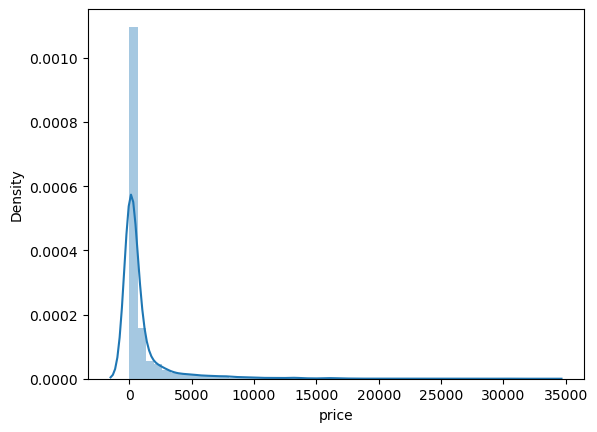

In [461]:
sns.distplot(abs(y_test-y_pred))

plt.show()

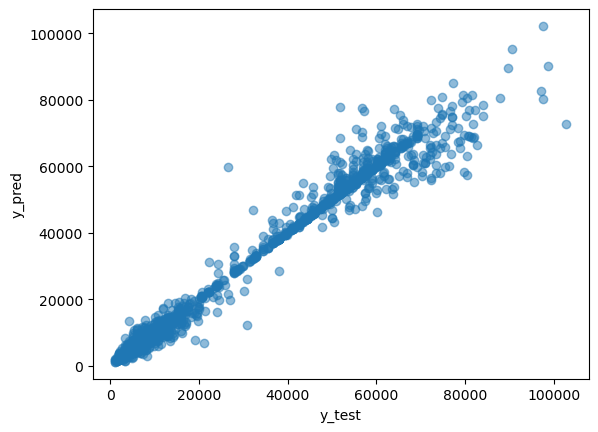

In [462]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

**Over 0.984 score is amazing for a model that does not know the day or the month**

In [463]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1006.1556322927572
MSE: 7259616.200890675
RMSE: 2694.3674955155384


In [464]:
import pickle
with open('flight.pkl', 'wb') as f:
    pickle.dump(reg_rf_meta, f)
print("sdffsd")

sdffsd


In [465]:
importances = reg_rf_meta.feature_importances_

# find index of duration feature in X_train.columns
duration_idx = X_train.columns.get_loc('stops')

# print importance score for duration feature
print(f"Importance score for duration feature: {importances[duration_idx]}")

Importance score for duration feature: 0.0017921620178416539


In [467]:
x=X.iloc[111]
def denem(x):
    x.stops=0
    print(reg_rf_meta.predict(x.to_frame().T))
    x.stops=1
    print(reg_rf_meta.predict(x.to_frame().T))
    x.stops=2
    print(reg_rf_meta.predict(x.to_frame().T))
denem(x)

[19952.01]
[19952.01]
[24547.97]


C:\Users\Salih\AppData\Local\Temp\ipykernel_13444\3349429672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.stops=0
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Salih\AppData\Local\Temp\ipykernel_13444\3349429672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.stops=1
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]